In [51]:
import pydotplus
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz 
from io import StringIO
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## __1 - Business Problem__  
___A cloth manufacturing company is interested to know about the segment or attributes causes high sale___  

## __2 - Data collection and description__ 

In [2]:
df = pd.read_csv("data/Company_Data.csv")

In [3]:
df1 = df.copy()

In [4]:
df1.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [5]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,400.0,7.496325,2.824115,0.0,5.39,7.49,9.32,16.27
CompPrice,400.0,124.975000,15.334512,77.0,115.00,125.00,135.00,175.00
Income,400.0,68.657500,27.986037,21.0,42.75,69.00,91.00,120.00
Advertising,400.0,6.635000,6.650364,0.0,0.00,5.00,12.00,29.00
Population,400.0,264.840000,147.376436,10.0,139.00,272.00,398.50,509.00
Price,400.0,115.795000,23.676664,24.0,100.00,117.00,131.00,191.00
Age,400.0,53.322500,16.200297,25.0,39.75,54.50,66.00,80.00
Education,400.0,13.900000,2.620528,10.0,12.00,14.00,16.00,18.00


In [6]:
df1.isnull().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [7]:
df1.dtypes

Sales          float64
CompPrice        int64
Income           int64
Advertising      int64
Population       int64
Price            int64
ShelveLoc       object
Age              int64
Education        int64
Urban           object
US              object
dtype: object

### Outlier Check

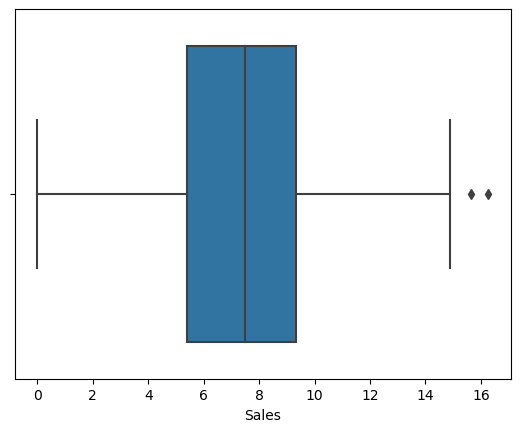

In [8]:
ax = sns.boxplot(df1['Sales'])

### The data has 2 outlier instances

In [9]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 0.18556036318721578
Kurtosis: -0.08087736743346197


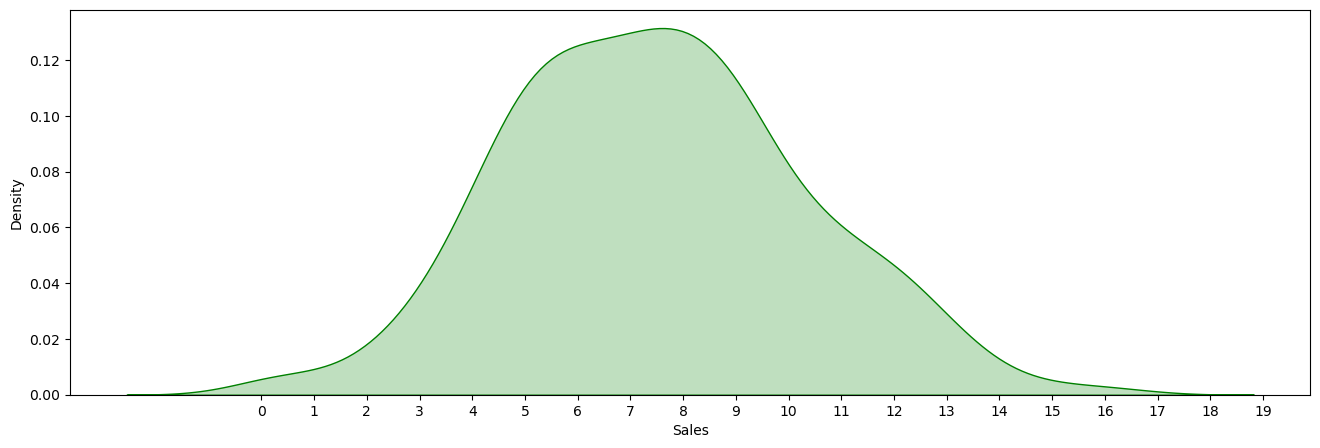

In [10]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['Sales'].skew()))
print("Kurtosis: {}".format(df1['Sales'].kurtosis()))
ax = sns.kdeplot(df1['Sales'],shade=True,color='g')
plt.xticks([i for i in range(0,20,1)])
plt.show()

### The data is Skwed on the right  
### The data has negative Kurtosis

In [11]:
obj_colum = df1.select_dtypes(include='object').columns.tolist()

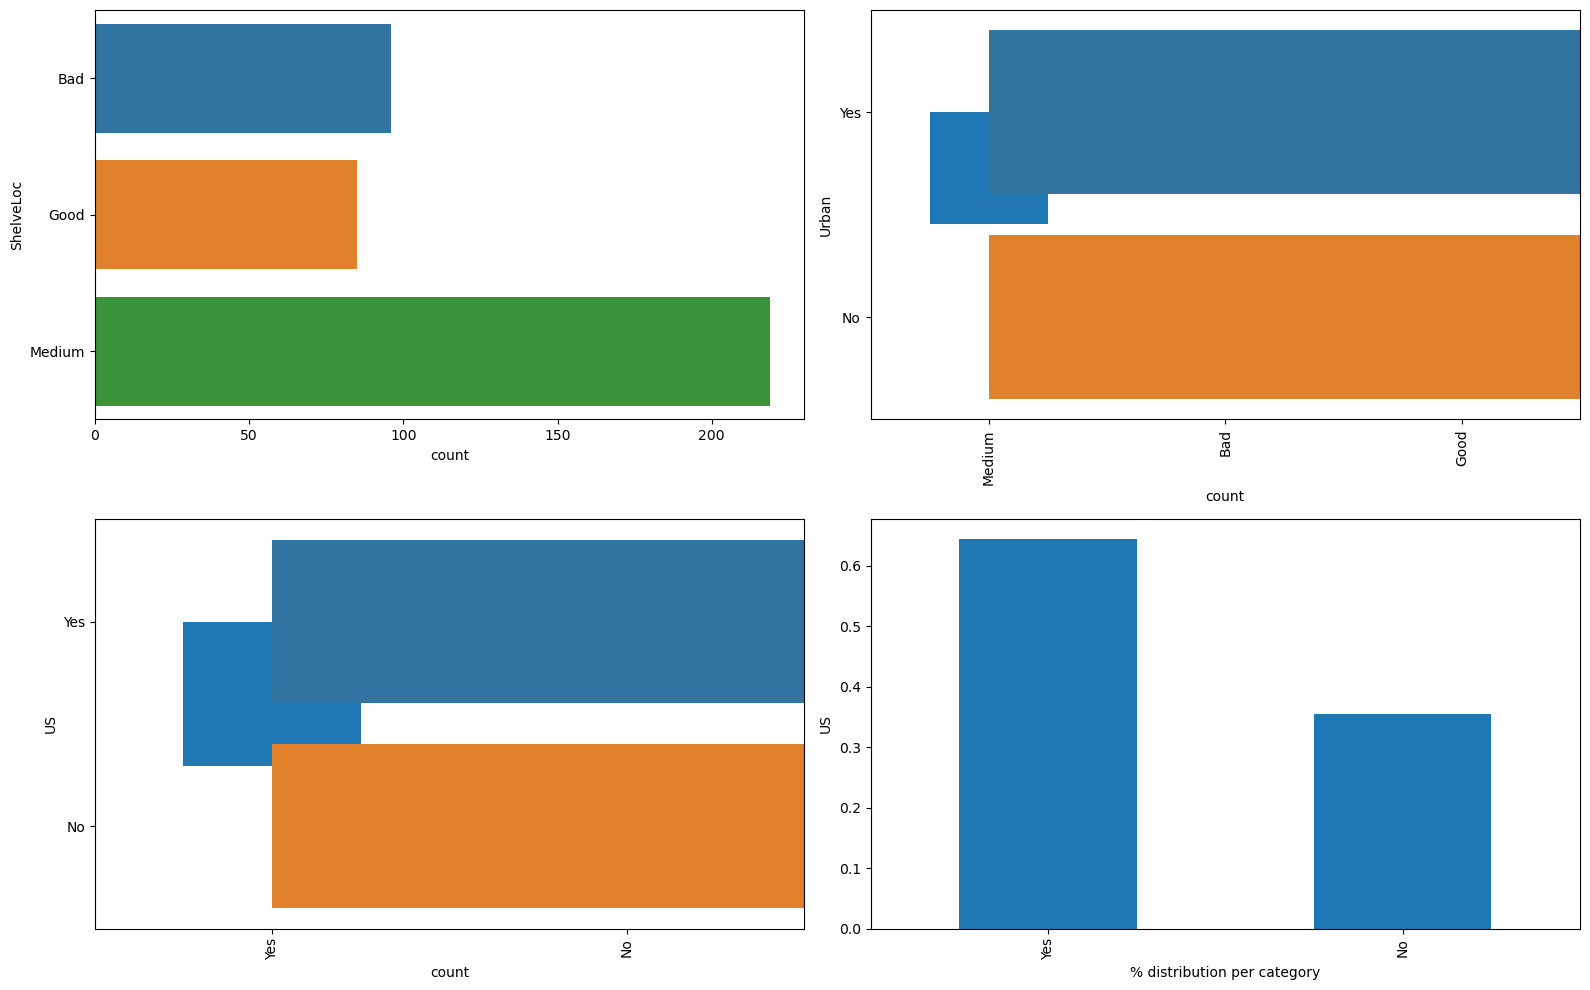

In [12]:
plt.figure(figsize=(16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=df1,y=col)
    plt.subplot(2,2,i+1)
    df1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()  

In [13]:
num_columns = df1.select_dtypes(exclude='object').columns.tolist()

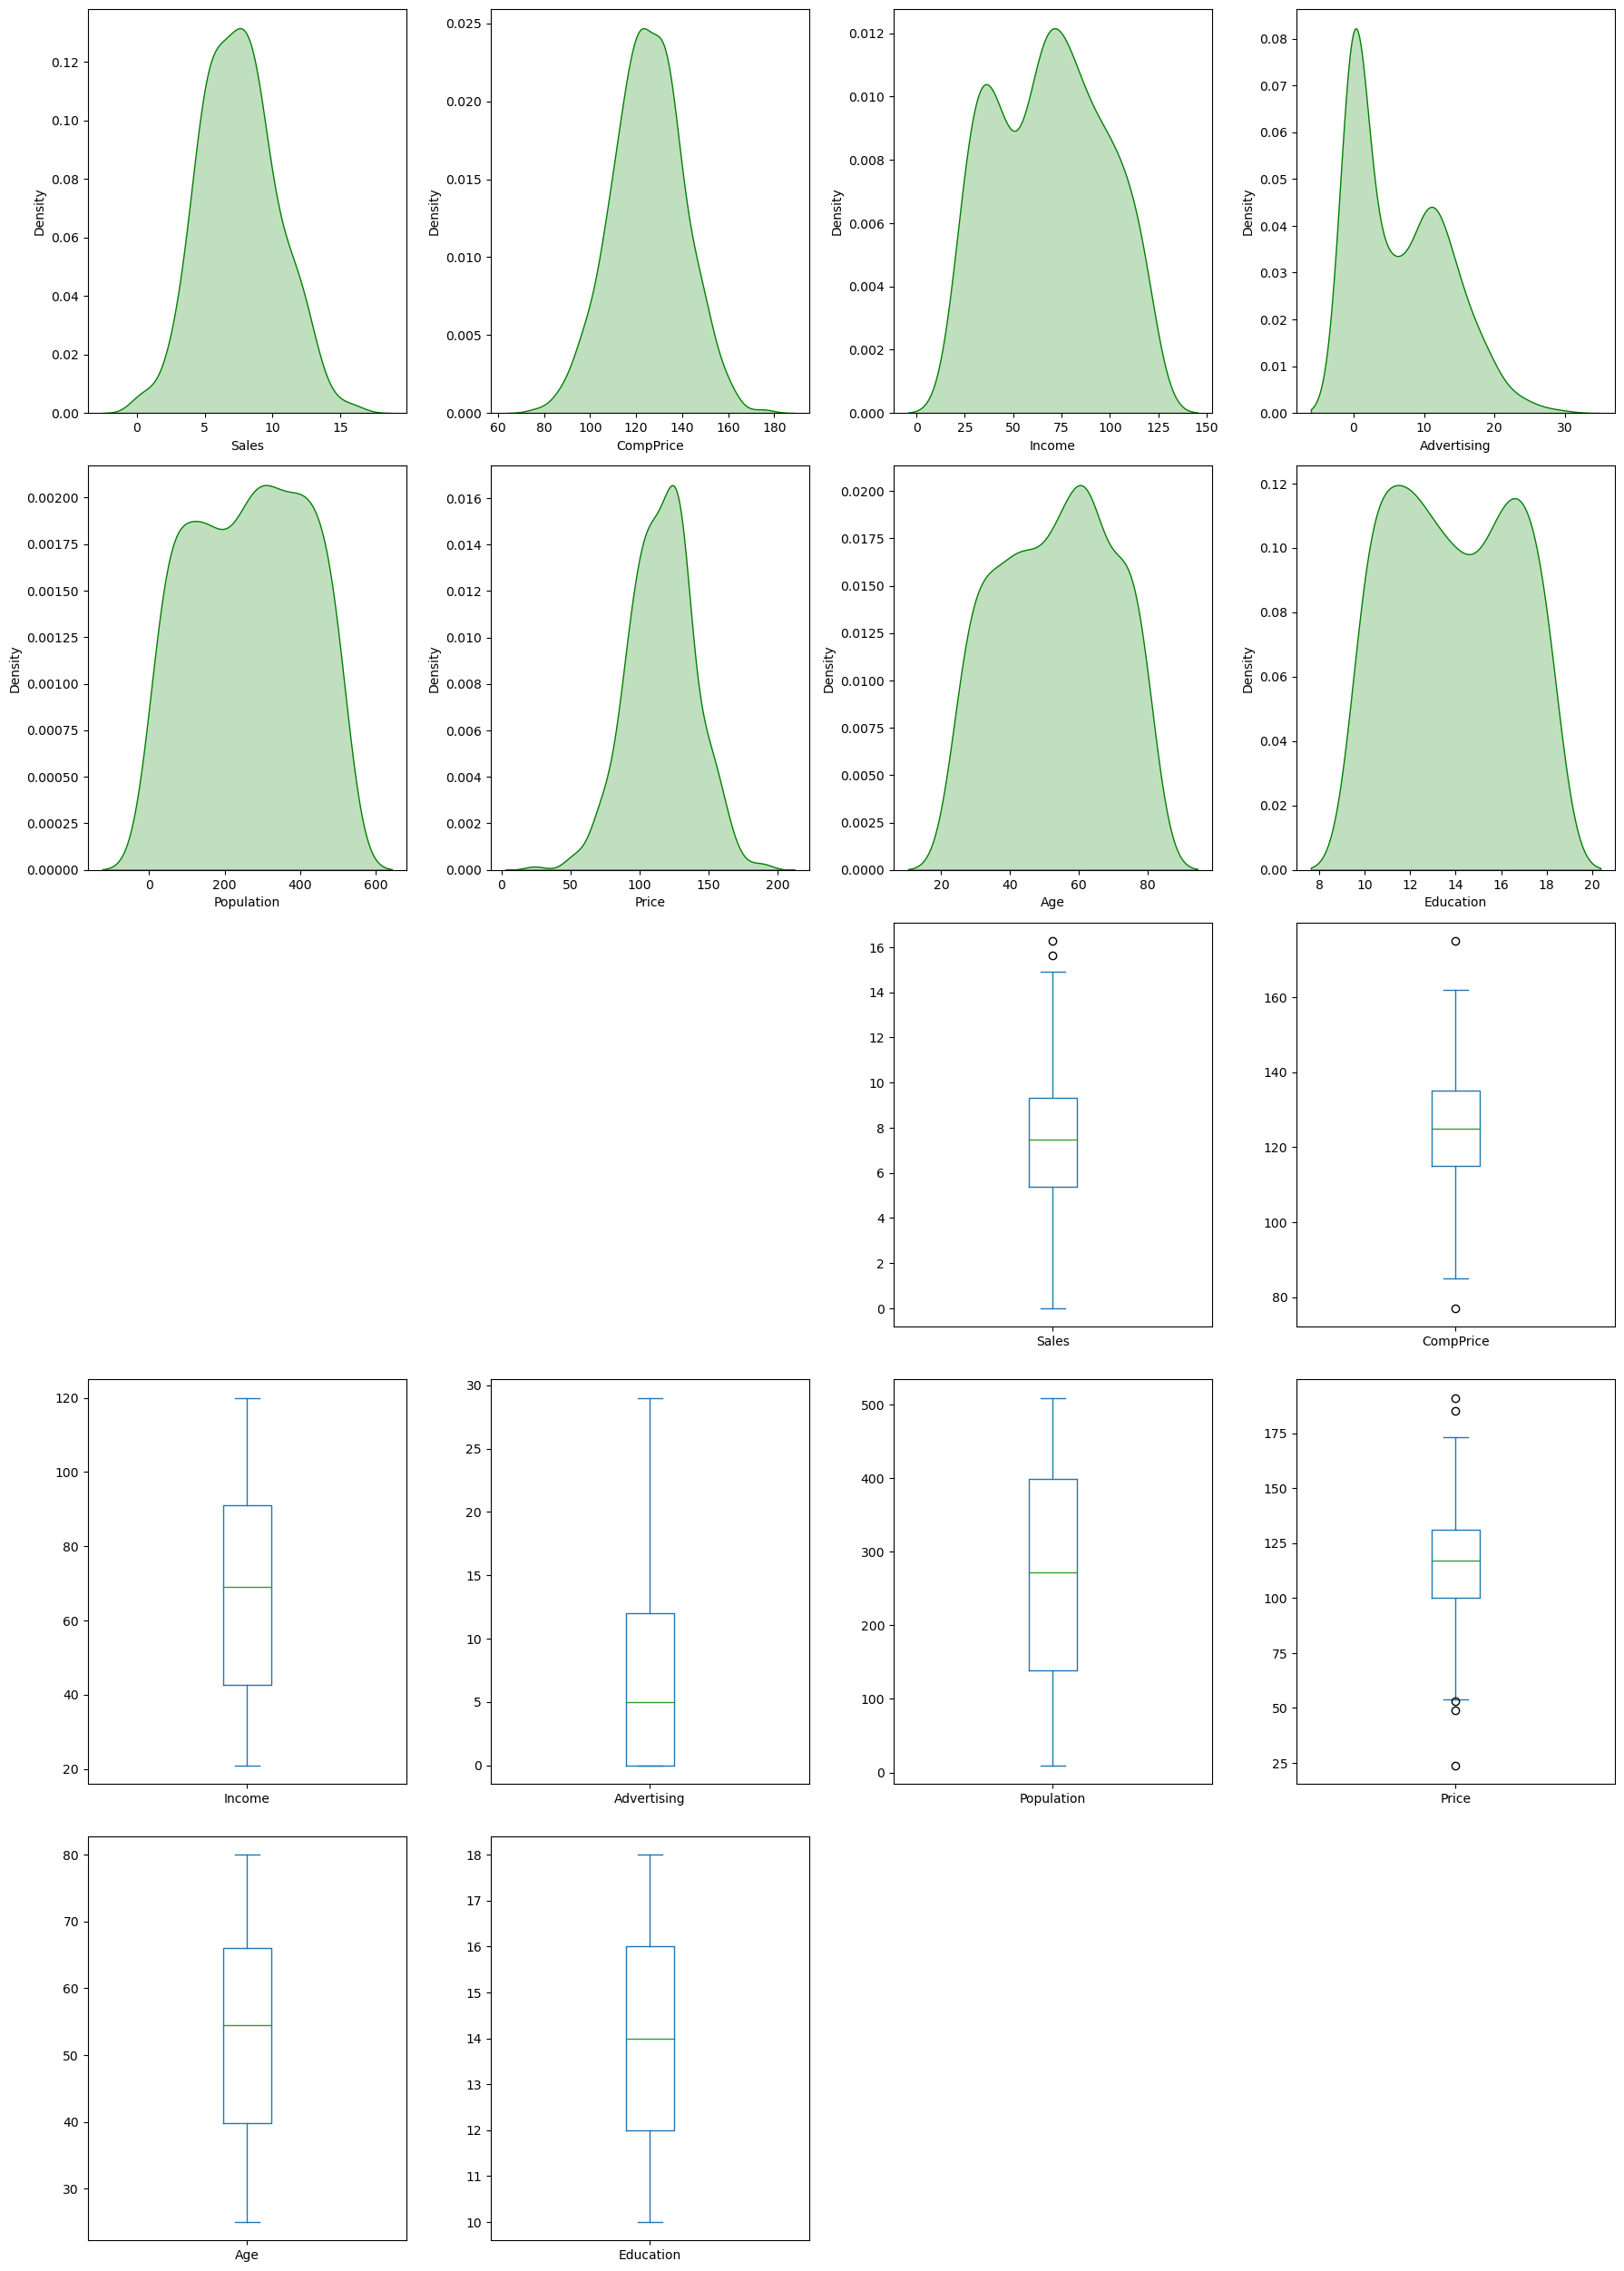

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
skewness,0.185560,-0.042755,0.049444,0.639586,-0.051227,-0.125286,-0.077182,0.044007
kurtosis,-0.080877,0.041666,-1.085289,-0.545118,-1.202318,0.451885,-1.134392,-1.298332


In [14]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    plt.subplot(8,4,i+10)
    df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [15]:
corr = df1.corr()

In [16]:
df1 = pd.get_dummies(df1, columns = ['ShelveLoc','Urban','US'])

In [17]:
corr = df1.corr()

<AxesSubplot:>

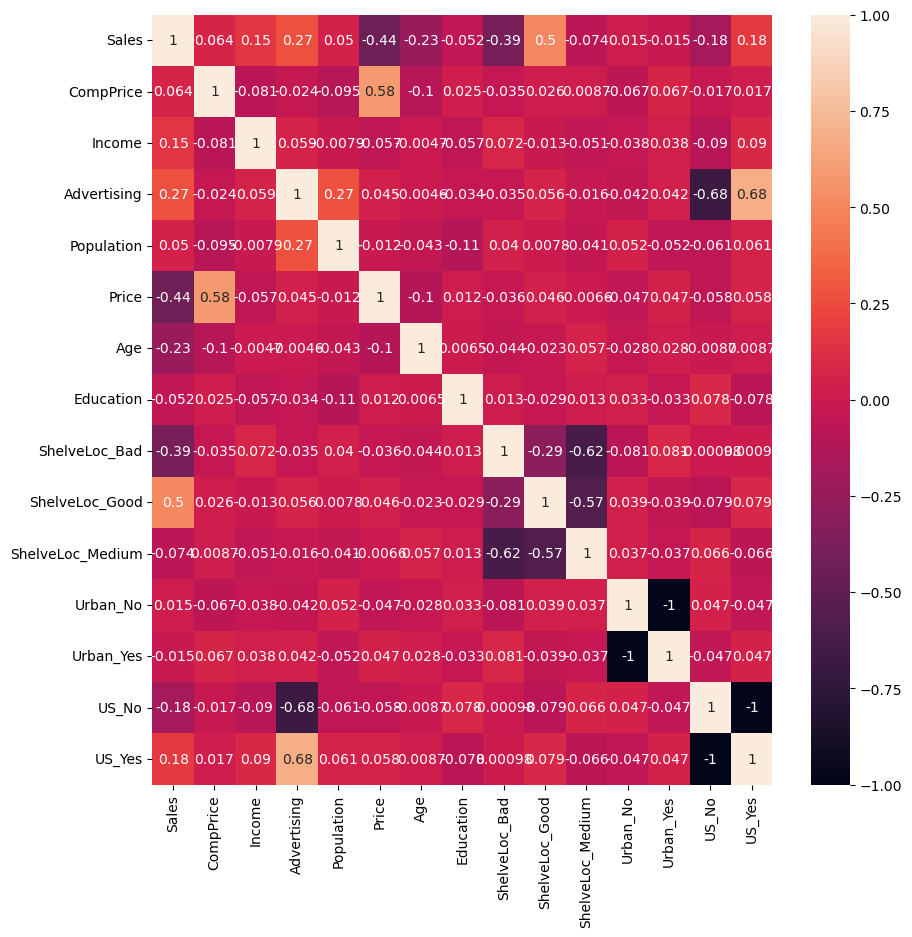

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

## __3 - Random Forest Model__ 

### Since the target variable is continious, we create a class of the value based on the mean  
### <= 7.49 == "Small" and > 7.49 == "large"

In [19]:
df1["sales"]="small"
df1.loc[df1["Sales"]>7.49,"sales"]="large"
df1.drop(["Sales"],axis=1,inplace=True)

In [20]:
X = df1.iloc[:,0:14]
y = df1.iloc[:,14]

In [21]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [22]:
y_train.value_counts()

large    166
small    154
Name: sales, dtype: int64

In [23]:
model =RF(n_jobs=4,n_estimators = 150, oob_score =True,criterion ='entropy') 
model.fit(x_train,y_train)
model.oob_score_

0.80625

In [24]:
pred_train = model.predict(x_train)

In [25]:
accuracy_score(y_train,pred_train)

1.0

In [26]:
confusion_matrix(y_train,pred_train)

array([[166,   0],
       [  0, 154]], dtype=int64)

In [27]:
pred_test = model.predict(x_test)

In [28]:
accuracy_score(y_test,pred_test)

0.825

In [29]:
confusion_matrix(y_test,pred_test)

array([[25,  8],
       [ 6, 41]], dtype=int64)

In [30]:
df_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})

In [31]:
df_t

,Actual,Predicted
163,small,small
174,small,small
61,small,small
160,small,small
176,small,small
...,...,...
270,large,large
287,small,large
367,large,large
229,large,large


In [32]:
cols = list(df1.columns)

In [33]:
predictors = cols[0:14]
target = cols[14]

In [34]:
tree1 = model.estimators_[20]

In [35]:
dot_data = StringIO()

In [36]:
export_graphviz(tree1, out_file = dot_data, feature_names =predictors, class_names = target, filled =True,rounded=True,impurity =False,proportion=False,precision =2)

In [37]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [38]:
graph.write_png('company_full.png')

True

## __4 - Conclusion__ 

### Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 76%  
### As seen in the confusion matrix of Test data 61 instances are presdected correctly and 19 instances are not

In [39]:
rf_small = RF(n_estimators=10, max_depth = 3)

In [40]:
rf_small.fit(x_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [41]:
tree_small = rf_small.estimators_[5]

In [42]:
export_graphviz(tree_small, out_file = dot_data, feature_names = predictors, rounded = True, precision = 1)

In [43]:
graph_small = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [44]:
graph.write_png('company_small.png')

True

In [45]:
img = mpimg.imread('company_small.png') 

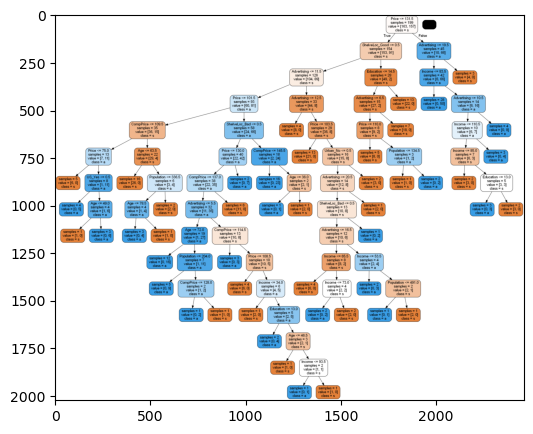

In [46]:
plt.imshow(img)

In [47]:
model.feature_importances_

array([0.11511452, 0.10550157, 0.09157412, 0.08747947, 0.22903362,
       0.12442057, 0.05988873, 0.03850624, 0.07149418, 0.02877821,
       0.01269109, 0.01027122, 0.01197307, 0.01327338])

In [48]:
fi = pd.DataFrame({'feature': list(x_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [49]:
fi

,feature,importance
4,Price,0.229034
5,Age,0.124421
0,CompPrice,0.115115
1,Income,0.105502
2,Advertising,0.091574
3,Population,0.087479
8,ShelveLoc_Good,0.071494
6,Education,0.059889
7,ShelveLoc_Bad,0.038506
9,ShelveLoc_Medium,0.028778


### As seen in the above table Price is most important feature